# Hyperparameter search results

Some results with the crossentropy, L1, L2, and TD-based method and various hyperparameters:

- Both methods seem robust to a growing horizon
- TD seems a bit less robust to poor hyperparameters, but its best hyperparameters outperform xent
- It's not clear that the high-magnitude ratios are a problem, perhaps Adam is saving us?
- L1 and L2 seem to have a hard time converging 


In [121]:
import pickle
import gzip
import torch
import numpy as np
import matplotlib.pyplot as pp
from collections import defaultdict
f32 = np.float32

# Some plotting routines
def binavg(x, n=100, var=False, bounds=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x
    bins = np.linspace(0, len(x), n)
    idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    y = np.bincount(idx, x, minlength=n) / np.bincount(idx, minlength=n)
    r = (bins, y)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - y**2)
        r += (var, )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n)]), ) 
    return r

def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, **kw):
    bins, y, var, bounds = binavg(x, n, var=True, bounds=True)
    if 'bins' in kw:
        bins = kw.pop('bins')
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l

In [2]:
res_mar_24 = [
    pickle.load(gzip.open(f'results/mar_24/{i}.pkl.gz')) for i in range(378)
]

In [55]:
res = res_mar_24
means_by = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
attrs = ['learning_method horizon', 'learning_method learning_rate', 'learning_method n_hid', 'learning_method uniform_sample_prob']
_attrs = set(sum([i.split() for i in attrs], []))
attr_ranges = defaultdict(set)
for exp in res:
    measures = {'KL': -np.float32(exp['p_dists'])[-10:, 1].mean(),
                'L1': np.float32(exp['p_dists'])[-10:, 0].mean(),}
    args = exp['args']
    for a in _attrs:
        attr_ranges[a].add(getattr(args, a))
    for attr in attrs:
        for k in measures.keys():
            means_by[attr][tuple(getattr(args, i) for i in attr.split(' '))][k].append(measures[k])

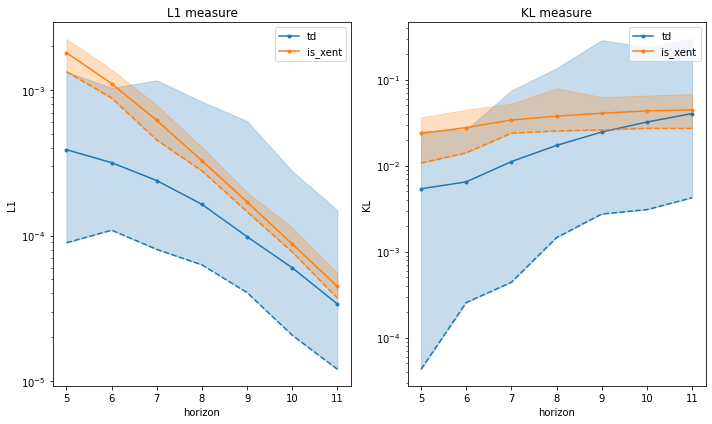

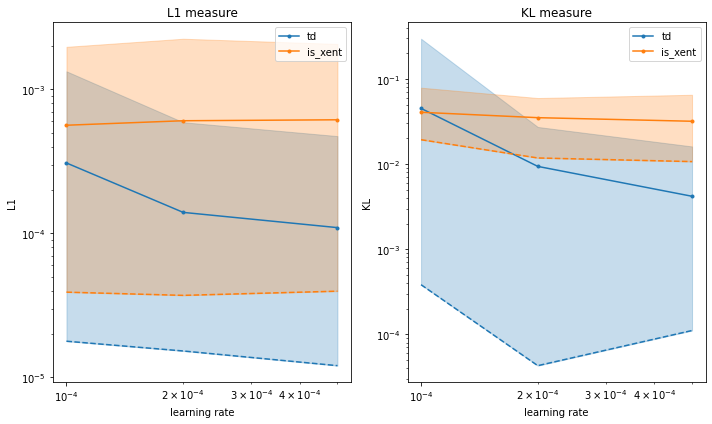

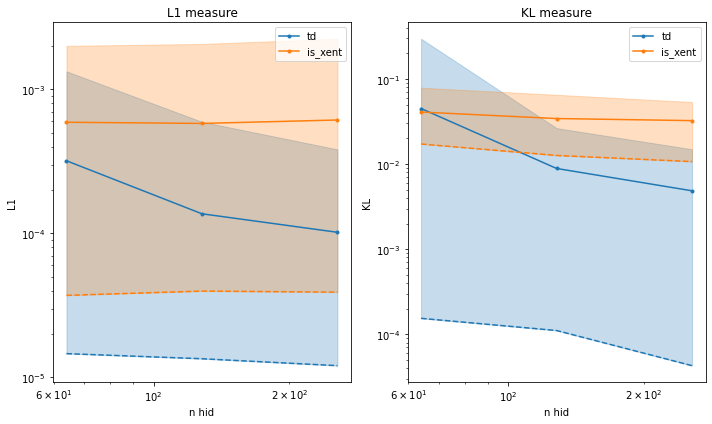

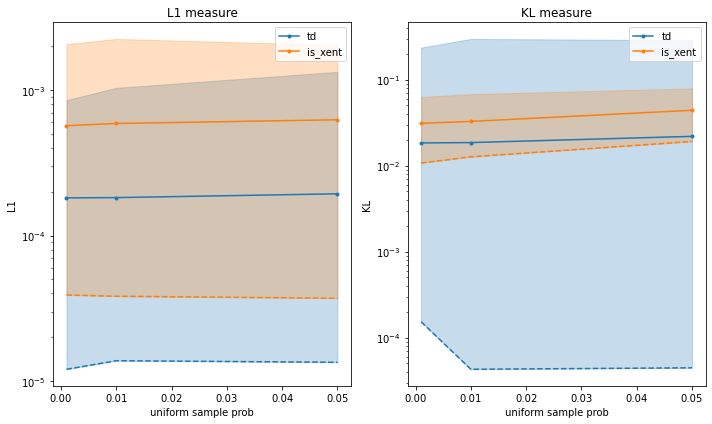

In [56]:
xlog_attrs = ['n_hid', 'learning_rate']
for attr in sorted(list(_attrs)):
    if f'learning_method {attr}' not in means_by:
        continue
    f, ax = pp.subplots(1,2,figsize=(10,6))
    for j, measure in enumerate(['L1', 'KL']):
        pp.sca(ax[j])
        pp.title(f'{measure} measure')
        xs = sorted(attr_ranges[attr])
        for method in ('td', 'is_xent'):
            pts = [means_by[f'learning_method {attr}'][(method, i)][measure]
                   for i in xs]
            ys = f32([np.mean(i) for i in pts])
            ts = f32([np.max(i) for i in pts])
            bs = f32([np.min(i) for i in pts])
            l, = pp.plot(xs, ys, label=method, marker='o', ms=3)
            pp.fill_between(xs, ts, bs, color=l.get_c(), alpha=0.25)
            pp.plot(xs, bs, ls='--', color=l.get_c())
        pp.legend()
        pp.ylabel(measure)
        pp.xlabel(attr.replace('_', ' '))
        pp.yscale('log')
        if attr in xlog_attrs:
            pp.xscale('log')
    pp.tight_layout()

## Plotting Importance Sampling ratios
For a limited horizon these ratios are of a "reasonable" magnitude, numerically seems stable. In practice though, this is much bigger than a "typical" loss for DNNs.

I think importantly, they seem highly concentrated in the upper range, which means that if we can have Adam adaptively compute learning rates, we don't need to handle high-ratio outliers.

In [57]:
res = pickle.load(gzip.open('/home/NOBACKUP/ebengi/LambdaZero/LambdaZero/examples/generative_models/results/mar_25_q/25.pkl.gz'))

Text(0.5, 1.0, 'density of ratios $r/\\pi$ during training (H=14)')

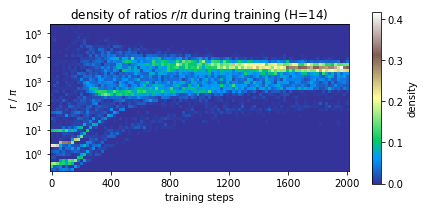

In [58]:
rs = res['training_ratios'][:, 0]
xr = np.int32(np.linspace(0, 100-1e-4, rs.shape[0]))
hists = []
logbins = np.linspace(-1.5, 12.5, 50)
for i in range(100):
    ri = np.log(rs[xr==i])
    h, _ = np.histogram(ri, bins=logbins)
    h = h / h.sum()
    hists.append(h)
hists = np.stack(hists)
im = pp.imshow(hists.T, origin='lower', interpolation='none', cmap='terrain')
true_ticks, tick_labels = np.float32([10**i for i in range(6)]), [f'$10^{i}$' for i in range(6)]
log_ticks = np.log(true_ticks)
ticks_ypos = hists.shape[1] * (log_ticks - logbins[0]) / (logbins[-1] - logbins[0])
pp.yticks(ticks_ypos, tick_labels)
pp.xticks(np.linspace(0, hists.shape[0]-1, 6), np.int32(np.linspace(0, 2000, 6)))
pp.ylabel('r / $\\pi$')
pp.xlabel('training steps')
cbar = pp.colorbar(im, fraction=0.026, pad=0.07)
cbar.ax.set_ylabel('density')#, rotation=270)
pp.tight_layout()
pp.title('density of ratios $r/\\pi$ during training (H=14)')

# Including L1/L2 objective results

In [122]:
import os
res_mar_24_l1l2 = ([
    pickle.load(gzip.open(f'results/mar_24/{i}.pkl.gz')) for i in range(378)
] + [
    pickle.load(gzip.open(f'results/apr_1/{i}.pkl.gz')) for i in range(378)])
    #pickle.load(gzip.open(f'results/l1/{i}')) for i in os.listdir('results/l1')]
  #+ [pickle.load(gzip.open(f'results/l2/{i}')) for i in os.listdir('results/l2')])


In [127]:
res = res_mar_24_l1l2
methods = ('td', 'is_xent', 'l1', 'l2')
means_by = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
attrs = ['learning_method horizon', 'learning_method learning_rate', 'learning_method n_hid', 'learning_method uniform_sample_prob']
_attrs = set(sum([i.split() for i in attrs], []))
attr_ranges = defaultdict(set)
method_best = defaultdict(lambda:defaultdict(lambda: (1e9,)))
for exp in res:
    measures = {'KL': -np.float32(exp['p_dists'])[-10:, 1].mean(),
                'L1': np.float32(exp['p_dists'])[-10:, 0].mean(),}
    args = exp['args']
    for m in measures:
        if args.horizon == 11 and measures[m] < method_best[m][args.learning_method][0]:
            method_best[m][args.learning_method] = (measures[m], args, exp)
    for a in _attrs:
        attr_ranges[a].add(getattr(args, a))
    for attr in attrs:
        for k in measures.keys():
            means_by[attr][tuple(getattr(args, i) for i in attr.split(' '))][k].append(measures[k])

## The best learned distributions

0.0042237183
Namespace(array='mar_24', bootstrap_tau=0.1, device='cpu', horizon=11, learning_method='td', learning_rate=0.0005, mbsize=8, momentum=0.0, n_hid=256, n_layers=2, n_train_steps=8000, progress=False, save_path='results/mar_24/376.pkl.gz', uniform_sample_prob=0.05)
0.027045498
Namespace(array='mar_24', bootstrap_tau=0.1, device='cpu', horizon=11, learning_method='is_xent', learning_rate=0.0005, mbsize=8, momentum=0.0, n_hid=256, n_layers=2, n_train_steps=8000, progress=False, save_path='results/mar_24/373.pkl.gz', uniform_sample_prob=0.001)
0.046594016
Namespace(adam_beta1=0.9, adam_beta2=0.999, array='apr_1', bootstrap_tau=0.1, device='cpu', do_is_queue=False, horizon=11, learning_method='l1', learning_rate=0.0005, mbsize=8, momentum=0.9, n_hid=128, n_layers=2, n_train_steps=8000, opt='adam', progress=False, queue_thresh=10, save_path='results/apr_1/368.pkl.gz', uniform_sample_prob=0.01)
0.3185122
Namespace(adam_beta1=0.9, adam_beta2=0.999, array='apr_1', bootstrap_tau=0.1, 

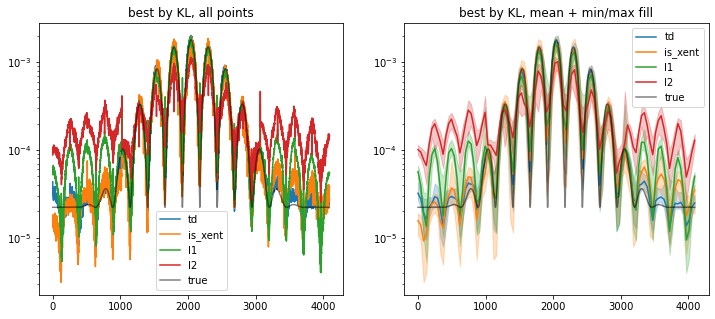

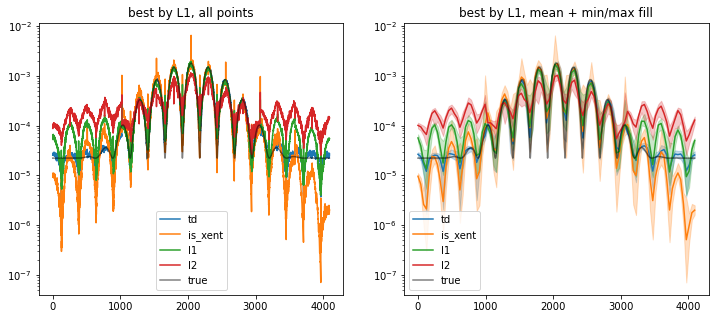

In [129]:
for m in sorted(method_best.keys()):
    f, ax = pp.subplots(1, 2, figsize=(12, 5))
    pp.sca(ax[0])
    pp.title(f'best by {m}, all points')
    for i in methods:
        l1, args, exp = method_best[m][i]
        print(l1)
        print(args)
        pp.plot(exp['est_d'], label=i)
    pp.plot(exp['true_d'], label='true', color='black', alpha=0.5)
    pp.yscale('log')
    pp.legend()
    pp.sca(ax[1])
    pp.title(f'best by {m}, mean + min/max fill')
    for i in methods:
        l1, args, exp = method_best[m][i]
        smooth_plot(exp['est_d'], fill_minmax=True, label=i)
    pp.plot(exp['true_d'], label='true', color='black', alpha=0.5)
    pp.yscale('log')
    pp.legend()

## Hyperparameter effects

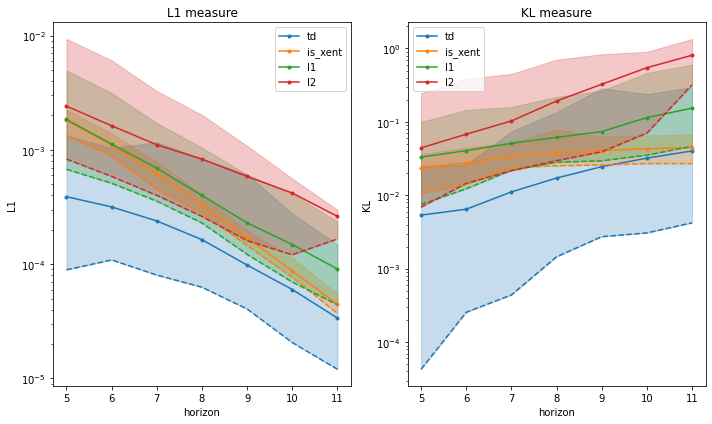

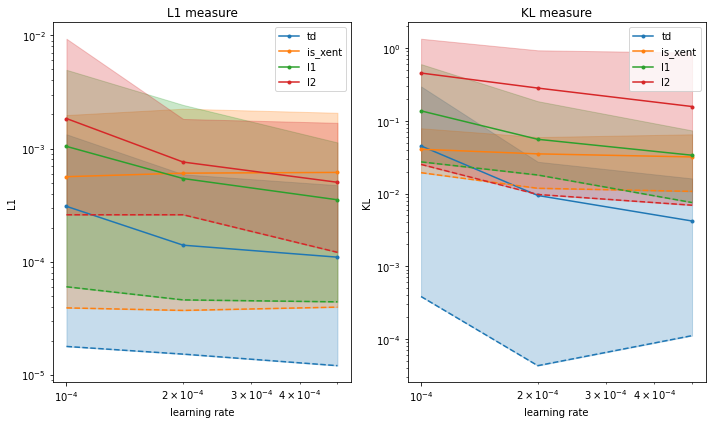

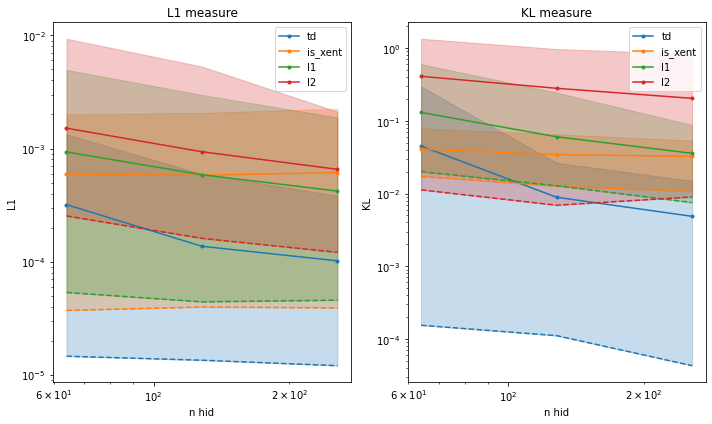

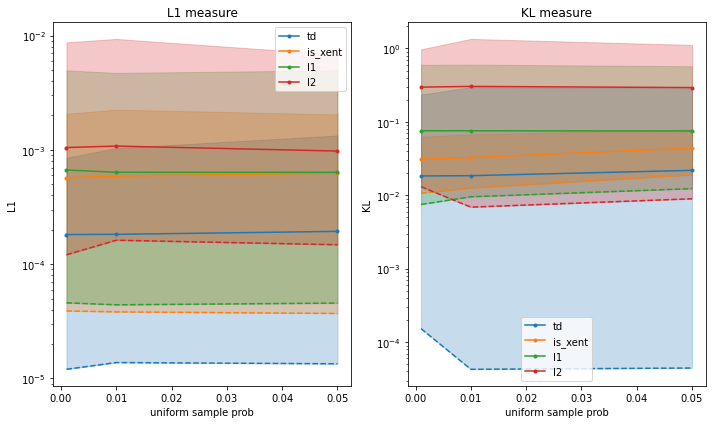

In [125]:
xlog_attrs = ['n_hid', 'learning_rate']
for attr in sorted(list(_attrs)):
    if f'learning_method {attr}' not in means_by:
        continue
    f, ax = pp.subplots(1,2,figsize=(10,6))
    for j, measure in enumerate(['L1', 'KL']):
        pp.sca(ax[j])
        pp.title(f'{measure} measure')
        xs = sorted(attr_ranges[attr])
        for method in methods:
            pts, _xs = zip(*[(j, i)
                   for i in xs
                   for j in [
                       [k for k in means_by[f'learning_method {attr}'][(method, i)][measure]
                        if np.isfinite(k)]] # removing failed runs, not necessarily a good idea...
                    if len(j)])
            ys = f32([np.mean(i) for i in pts])
            ts = f32([np.max(i) for i in pts])
            bs = f32([np.min(i) if len(i) else np.nan for i in pts])
            l, = pp.plot(_xs, ys, label=method, marker='o', ms=3)
            pp.fill_between(_xs, ts, bs, color=l.get_c(), alpha=0.25)
            pp.plot(_xs, bs, ls='--', color=l.get_c())
        pp.legend()
        pp.ylabel(measure)
        pp.xlabel(attr.replace('_', ' '))
        pp.yscale('log')
        if attr in xlog_attrs:
            pp.xscale('log')
    
    pp.tight_layout()